# Eksploracyjna Analiza Danych

**Cel:** Zrozumienie struktury danych, identyfikacja wzorców i anomalii przed feature engineeringiem

Ten notebook zawiera:
- Analizę rozkładów zmiennych
- Identyfikację outlierów
- Korelację między features
- Wnioski kluczowe dla modelowania

Import bibliotek i wczytanie danych

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Konfiguracja wykresów
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Ścieżki
TRAIN_PATH = Path("data-task/train.csv")
TEST_PATH = Path("data-task/test.csv")

# Wczytaj dane
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nKolumny:\n{train.columns.tolist()}")

Train shape: (750000, 12)
Test shape: (250000, 11)

Kolumny:
['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes', 'Genre', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Listening_Time_minutes']


Analiza braków danych

**Dlaczego to ważne?**
- Braki mogą być informatywne (np. brak goscia = podcast solo)

In [3]:
def analyze_missing(df, name):
    """Szczegółowa analiza brakujących wartości"""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percent': missing_pct
    }).sort_values('Missing_Percent', ascending=False)
    
    print(f"\n{'='*60}")
    print(f"ANALIZA BRAKÓW - {name}")
    print(f"{'='*60}")
    print(missing_df[missing_df['Missing_Count'] > 0])
    
    return missing_df

train_missing = analyze_missing(train, "TRAIN")
test_missing = analyze_missing(test, "TEST")

# Porównanie braków train vs test
print(f"\n{'='*60}")
print("PORÓWNANIE BRAKÓW (Train vs Test)")
print(f"{'='*60}")
comparison = pd.DataFrame({
    'Train_%': train_missing['Missing_Percent'],
    'Test_%': test_missing['Missing_Percent']
})
print(comparison[comparison['Train_%'] > 0])


ANALIZA BRAKÓW - TRAIN
                             Missing_Count  Missing_Percent
Guest_Popularity_percentage         146030            19.47
Episode_Length_minutes               87093            11.61
Number_of_Ads                            1             0.00

ANALIZA BRAKÓW - TEST
                             Missing_Count  Missing_Percent
Guest_Popularity_percentage          48832            19.53
Episode_Length_minutes               28736            11.49

PORÓWNANIE BRAKÓW (Train vs Test)
                             Train_%  Test_%
Episode_Length_minutes         11.61   11.49
Guest_Popularity_percentage    19.47   19.53


**Kluczowe wnioski:**

1. **Episode_Length_minutes** (~11.5% braków):
    - Występuje w train i test w podobnym %
    - Moze jest zwiazane z typem podcastu??
    - Dodamy flagę + zamienimy medianą

2. **Guest_Popularity_Percentage** (~19.5% braków):
    - Dużo braków, ale konsystentny train/test
    - Podcast solo = wyższa lub niższa słuchalność?
    - Flaga missing będzie fajnym predyktorem

3. **Number_of_Ads** (1 brak)
    - 1 brak -> wywalamy

Statystyki opisowe zmiennych numerycznych

In [4]:
print(f"\n{'='*60}")
print("STATYSTYKI OPISOWE - TRAIN")
print(f"{'='*60}")

numeric_cols = train.select_dtypes(include=[np.number]).columns
print(train[numeric_cols].describe().T)


STATYSTYKI OPISOWE - TRAIN
                                count           mean            std  min  \
id                           750000.0  374999.500000  216506.495284  0.0   
Episode_Length_minutes       662907.0      64.504738      32.969603  0.0   
Host_Popularity_percentage   750000.0      59.859901      22.873098  1.3   
Guest_Popularity_percentage  603970.0      52.236449      28.451241  0.0   
Number_of_Ads                749999.0       1.348855       1.151130  0.0   
Listening_Time_minutes       750000.0      45.437406      27.138306  0.0   

                                      25%           50%           75%  \
id                           187499.75000  374999.50000  562499.25000   
Episode_Length_minutes           35.73000      63.84000      94.07000   
Host_Popularity_percentage       39.41000      60.05000      79.53000   
Guest_Popularity_percentage      28.38000      53.58000      76.60000   
Number_of_Ads                     0.00000       1.00000       2.00000   
L

Rozklady zmiennych numerycznych

**Dlaczego ważne?**
    - Zrozumienie skośności -> może wymagać transformacji
    - Outliery?
    - Sprawdzenie czy target jest w miare normalny (dla regresji)

Wykres zapisany: distributions_numeric.png


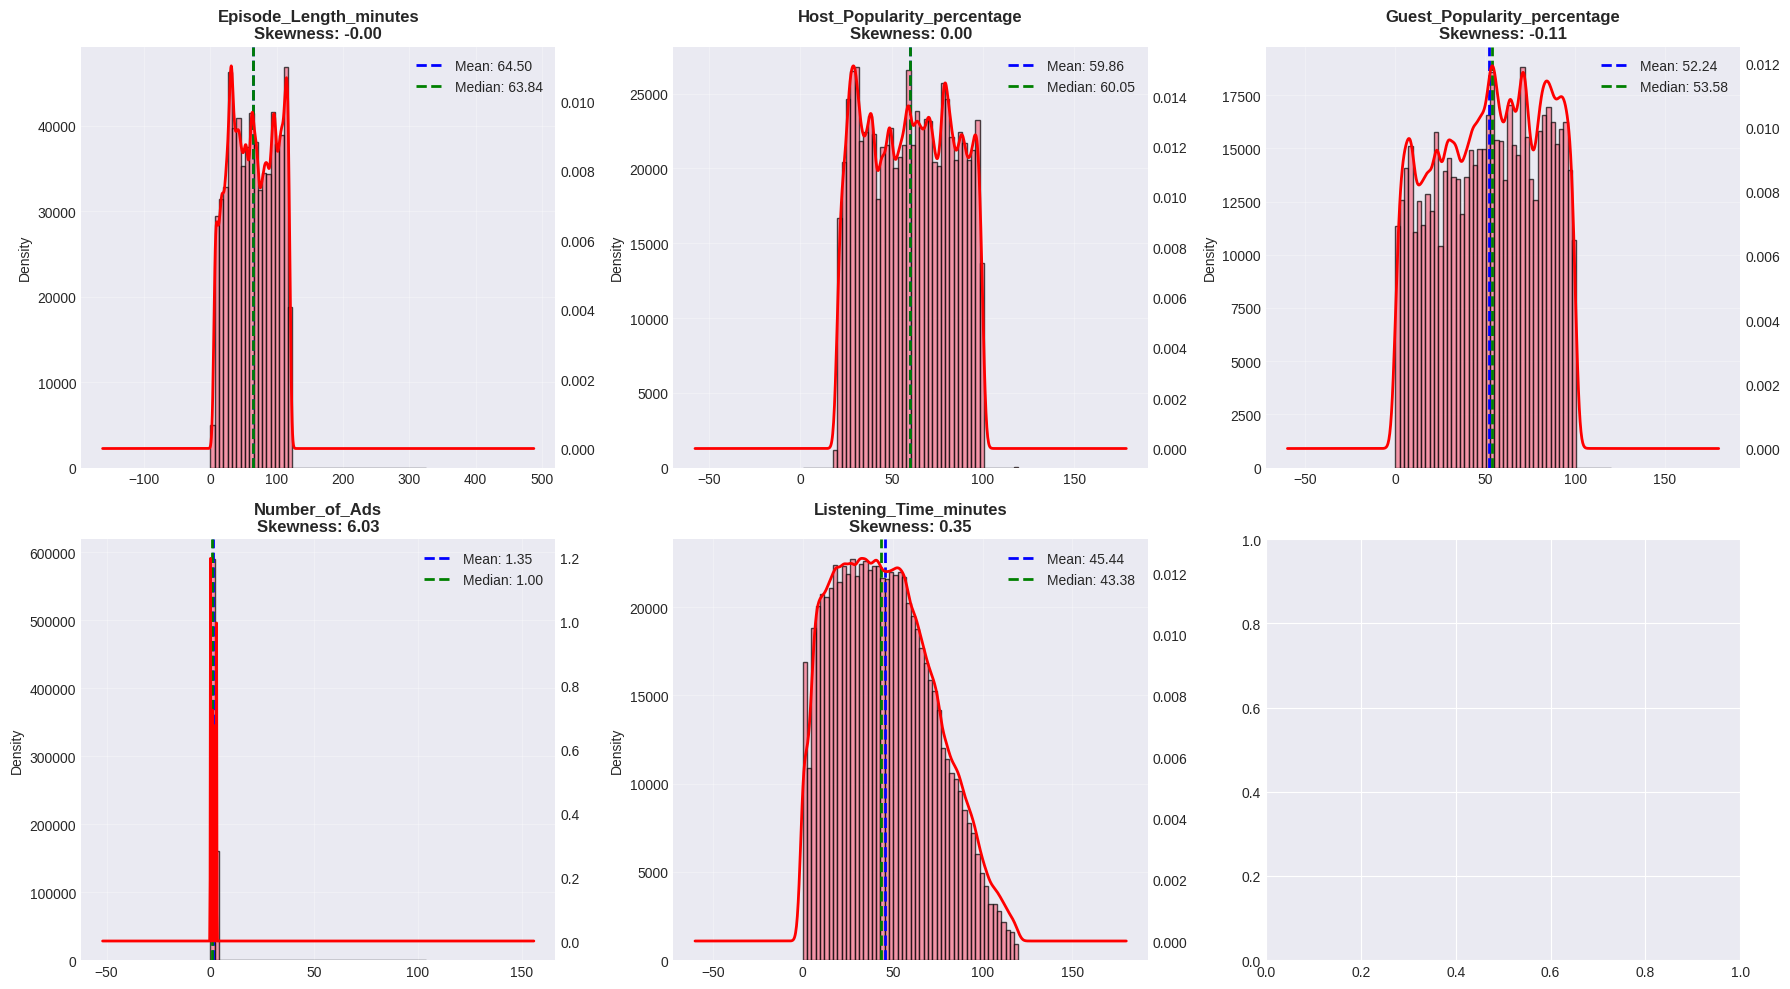


ANALIZA SKOŚNOŚCI (Skewness)
Episode_Length_minutes         | Skewness:  -0.00 | Symetryczna
Host_Popularity_percentage     | Skewness:   0.00 | Symetryczna
Guest_Popularity_percentage    | Skewness:  -0.11 | Symetryczna
Number_of_Ads                  | Skewness:   6.03 | Silnie prawostronna
Listening_Time_minutes         | Skewness:   0.35 | Symetryczna


In [5]:
numeric_features = [
    'Episode_Length_minutes', 
    'Host_Popularity_percentage',
    'Guest_Popularity_percentage', 
    'Number_of_Ads', 
    'Listening_Time_minutes'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    
    # Histogram + KDE
    train[col].dropna().hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
    train[col].dropna().plot(kind='kde', ax=ax, secondary_y=True, color='red', linewidth=2)
    
    # Statystyki
    mean_val = train[col].mean()
    median_val = train[col].median()
    skew_val = train[col].skew()
    
    ax.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    ax.set_title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distributions_numeric.png', dpi=150, bbox_inches='tight')
print("Wykres zapisany: distributions_numeric.png")
plt.show()

# Analiza skośności
print(f"\n{'='*60}")
print("ANALIZA SKOŚNOŚCI (Skewness)")
print(f"{'='*60}")
for col in numeric_features:
    skew = train[col].skew()
    interpretation = "Silnie prawostronna" if skew > 1 else "Lekko prawostronna" if skew > 0.5 else "Symetryczna" if abs(skew) <= 0.5 else "Lewostronna"
    print(f"{col:30s} | Skewness: {skew:6.2f} | {interpretation}")

**Kluczowe wbioski z rozkładów:**

1. **Eposode_length_minutes:**
    - malutka prawostronna skośność -> dlugie odcinki sa zadkie
    - wiekszosc odcinkow w przedziale od 30 do 90 minut
    - co z tym zrobic? Winsorization lepszy niż usuwanie outlierów

2. **Host/Guest_Popularity_Percentage:**
    - W miarę symetryczne -> jest git, dobra dystrubucja
    - median/mean imputation jest ok

3. **Number_of_Ads:**
    - Dyskretna (0, 1, 2, 3)
    - Traktować jako kategoryczna

4. **Listening_Time_Minutes**
    - skośność, sprawdzić czy < 1.0 (git dla regresji)
    - leśli > 1.0 -> moze lepsza log-transform?

Boxploty - identyfikacja outlierów

**Dlaczego ważne?**
    - outliery mogą byc błędami danych albo prawdziwymi ekstremami
    - usunięcie vs clipping (winsorization) -> wplyw na rmse

Wykres zapisany: boxplots_outliers.png


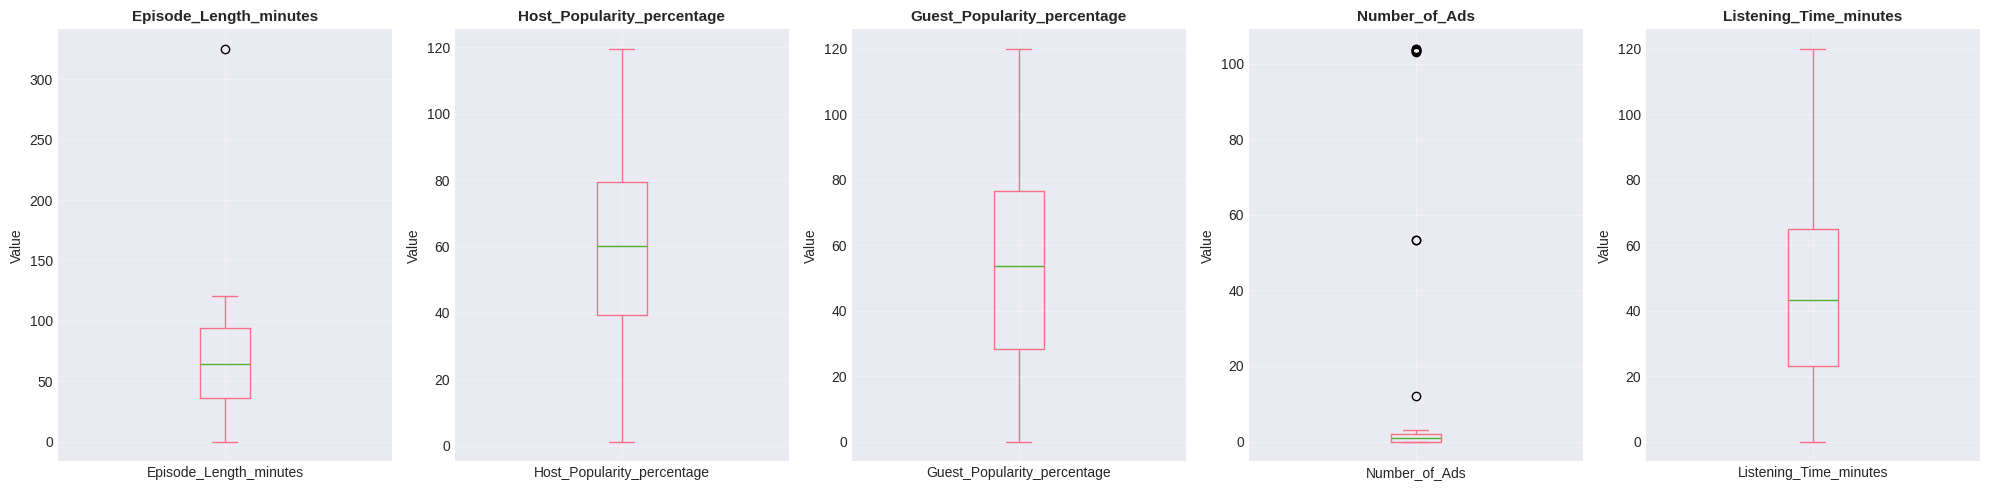


ANALIZA OUTLIERÓW (IQR Method)
Episode_Length_minutes         | Outliers:      1 ( 0.00%) | Range: [-51.78, 181.58]
Host_Popularity_percentage     | Outliers:      0 ( 0.00%) | Range: [-20.77, 139.71]
Guest_Popularity_percentage    | Outliers:      0 ( 0.00%) | Range: [-43.95, 148.93]
Number_of_Ads                  | Outliers:      9 ( 0.00%) | Range: [-3.00, 5.00]
Listening_Time_minutes         | Outliers:      0 ( 0.00%) | Range: [-39.27, 127.26]


In [8]:
fig, axes = plt.subplots(1, len(numeric_features), figsize=(20, 5))

for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    train[col].dropna().plot(kind='box', ax=ax, vert=True)
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('boxplots_outliers.png', dpi=150, bbox_inches='tight')
print("Wykres zapisany: boxplots_outliers.png")
plt.show()

# Statystyki outlierów (IQR method)
print(f"\n{'='*60}")
print("ANALIZA OUTLIERÓW (IQR Method)")
print(f"{'='*60}")

for col in numeric_features:
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outliers = train[(train[col] < lower) | (train[col] > upper)][col]
    outlier_pct = len(outliers) / len(train) * 100
    
    print(f"{col:30s} | Outliers: {len(outliers):6d} ({outlier_pct:5.2f}%) | Range: [{lower:.2f}, {upper:.2f}]")

**Wnioski z outlierów:**

**Episode_Length_minutes/Number_of_Ads:**
    - 10 outlierów na całym secie
    - imo winsorization (wywalenie do 1/99 percentile)
    - zachowujemy wszystkie wiersze, tylko ograniczamy ekstremalne wartości
    - moze pozytywnie wplynac na rmse (i guess wiecej danych treningowych? xd)

Analiza zmiennych kategorycznych

In [9]:
categorical_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 
                    'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

print(f"\n{'='*60}")
print("STATYSTYKI ZMIENNYCH KATEGORYCZNYCH")
print(f"{'='*60}")

for col in categorical_cols:
    n_unique = train[col].nunique()
    top_value = train[col].value_counts().index[0]
    top_count = train[col].value_counts().iloc[0]
    top_pct = (top_count / len(train) * 100)
    
    print(f"\n{col}:")
    print(f"  Unique values: {n_unique}")
    print(f"  Top value: '{top_value}' ({top_count} rows, {top_pct:.2f}%)")
    
    if n_unique <= 20:
        print(f"  Distribution:\n{train[col].value_counts().head(10)}")


STATYSTYKI ZMIENNYCH KATEGORYCZNYCH

Podcast_Name:
  Unique values: 48
  Top value: 'Tech Talks' (22847 rows, 3.05%)

Episode_Title:
  Unique values: 100
  Top value: 'Episode 71' (10515 rows, 1.40%)

Genre:
  Unique values: 10
  Top value: 'Sports' (87606 rows, 11.68%)
  Distribution:
Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64

Publication_Day:
  Unique values: 7
  Top value: 'Sunday' (115946 rows, 15.46%)
  Distribution:
Publication_Day
Sunday       115946
Monday       111963
Friday       108237
Wednesday    107886
Thursday     104360
Saturday     103505
Tuesday       98103
Name: count, dtype: int64

Publication_Time:
  Unique values: 4
  Top value: 'Night' (196849 rows, 26.25%)
  Distribution:
Publication_Time
Night        196849
Evening      195778
Afternoon    179460
Morning      177913
Name: c

rozklad Publication_Day i Publication_Time

**Dlaczego ważne?**
    - czas publikacji może korelować ze słuchalnością
    - można stwotzyc features: is_weekend, is_primetime, ...

Wykres zapisany: distribution_time.png


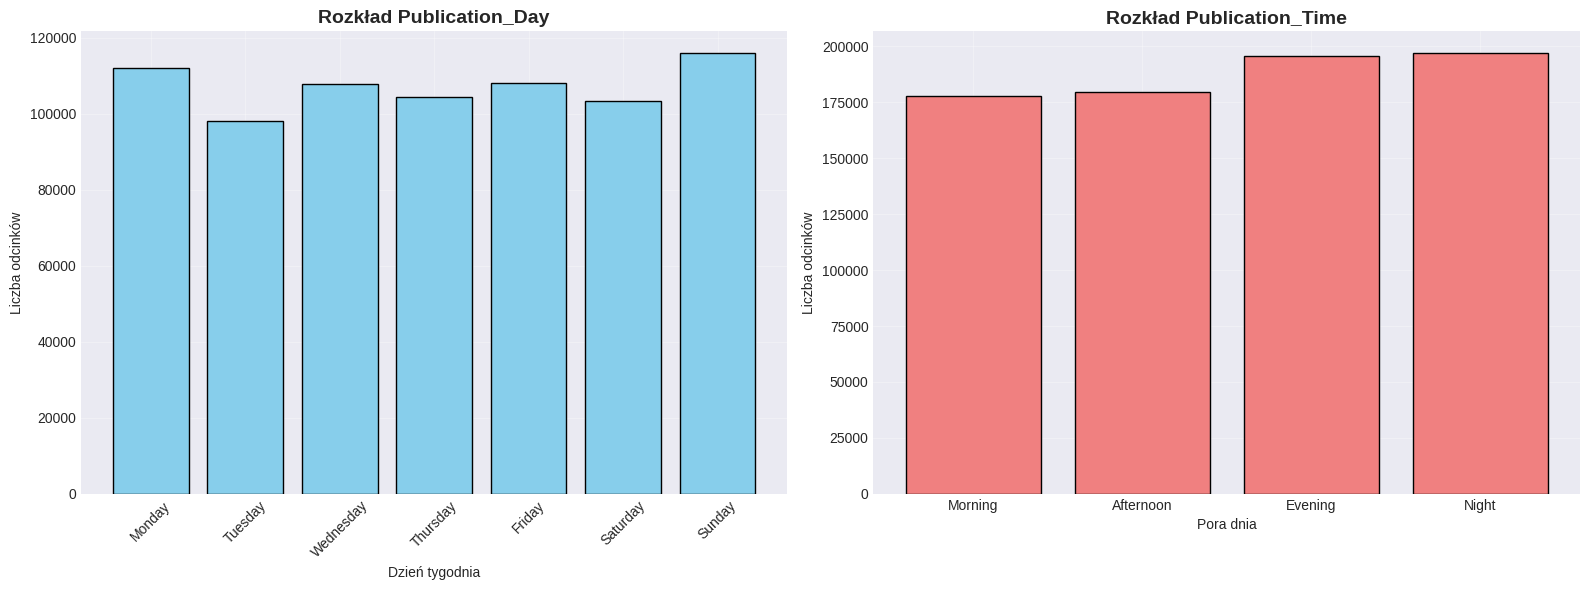


ŚREDNIA LISTENING_TIME per Publication_Day
                  mean  median    std
Publication_Day                      
Friday           45.21   42.89  27.20
Monday           45.97   44.23  26.63
Saturday         45.33   42.26  27.36
Sunday           44.82   42.84  26.79
Thursday         44.87   42.23  27.82
Tuesday          46.13   44.41  27.15
Wednesday        45.81   44.51  27.05

ŚREDNIA LISTENING_TIME per Publication_Time
                   mean  median    std
Publication_Time                      
Afternoon         45.53   43.55  27.34
Evening           44.76   42.45  26.96
Morning           44.96   42.50  27.29
Night             46.46   44.83  26.96


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Publication_Day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = train['Publication_Day'].value_counts().reindex(day_order)
axes[0].bar(day_counts.index, day_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Rozkład Publication_Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dzień tygodnia')
axes[0].set_ylabel('Liczba odcinków')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Publication_Time
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
time_counts = train['Publication_Time'].value_counts().reindex(time_order)
axes[1].bar(time_counts.index, time_counts.values, color='lightcoral', edgecolor='black')
axes[1].set_title('Rozkład Publication_Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pora dnia')
axes[1].set_ylabel('Liczba odcinków')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribution_time.png', dpi=150, bbox_inches='tight')
print("Wykres zapisany: distribution_time.png")
plt.show()

# Średnia słuchalność per dzień/pora
print(f"\n{'='*60}")
print("ŚREDNIA LISTENING_TIME per Publication_Day")
print(f"{'='*60}")
print(train.groupby('Publication_Day')['Listening_Time_minutes'].agg(['mean', 'median', 'std']).round(2))

print(f"\n{'='*60}")
print("ŚREDNIA LISTENING_TIME per Publication_Time")
print(f"{'='*60}")
print(train.groupby('Publication_Time')['Listening_Time_minutes'].agg(['mean', 'median', 'std']).round(2))

**Wnioski z czasu publikacji:**
1. jesli weekend ma najwyzsza srednia -> is_weekend to dobry feature
2. jeśli evening ma najwyższą -> is_primttime (17-21) = dobry feature

Analiza Genre

**Dlaczego to ważne:**
1. Różne gatunki mogą mieć różne wzorce słuchalności
2. target encoding per Genre może być silny

Wykres zapisany: genre_analysis.png


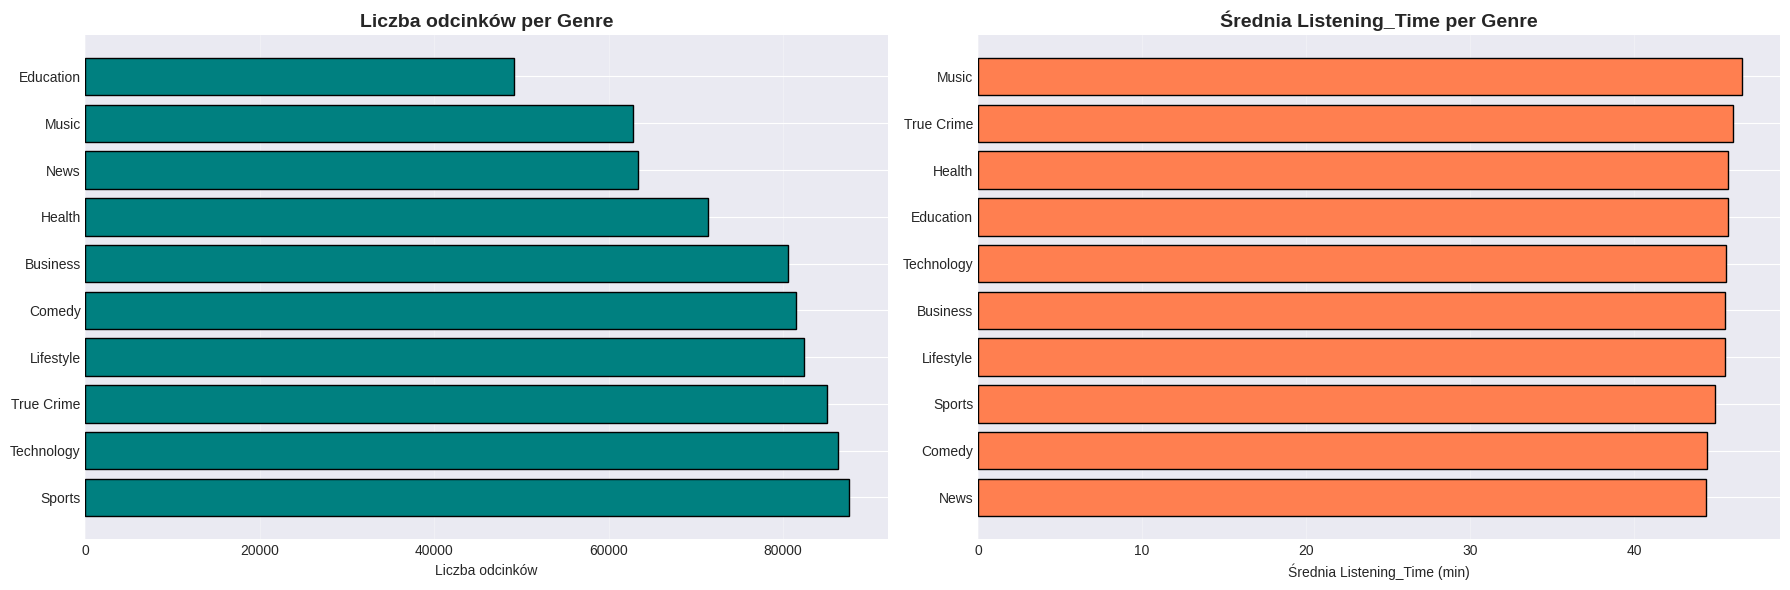


STATYSTYKI PER GENRE
           Listening_Time_minutes                      Episode_Length_minutes  \
                            count   mean median    std                   mean   
Genre                                                                           
Business                    80521  45.54  43.30  27.02                  64.54   
Comedy                      81453  44.43  41.95  26.94                  63.30   
Education                   49100  45.74  43.94  27.43                  64.98   
Health                      71416  45.74  44.51  27.12                  65.29   
Lifestyle                   82461  45.52  43.53  27.17                  64.84   
Music                       62743  46.58  44.22  27.48                  65.99   
News                        63385  44.41  42.00  26.81                  63.72   
Sports                      87606  44.94  43.47  26.12                  64.29   
Technology                  86256  45.63  42.90  27.90                  64.03   
True C

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Liczba odcinków per genre
genre_counts = train['Genre'].value_counts()
axes[0].barh(genre_counts.index, genre_counts.values, color='teal', edgecolor='black')
axes[0].set_title('Liczba odcinków per Genre', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Liczba odcinków')
axes[0].grid(True, alpha=0.3, axis='x')

# Średnia słuchalność per genre
genre_listening = train.groupby('Genre')['Listening_Time_minutes'].mean().sort_values()
axes[1].barh(genre_listening.index, genre_listening.values, color='coral', edgecolor='black')
axes[1].set_title('Średnia Listening_Time per Genre', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Średnia Listening_Time (min)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('genre_analysis.png', dpi=150, bbox_inches='tight')
print("Wykres zapisany: genre_analysis.png")
plt.show()

# Statystyki per genre
print(f"\n{'='*60}")
print("STATYSTYKI PER GENRE")
print(f"{'='*60}")
genre_stats = train.groupby('Genre').agg({
    'Listening_Time_minutes': ['count', 'mean', 'median', 'std'],
    'Episode_Length_minutes': 'mean',
    'Number_of_Ads': 'mean'
}).round(2)
print(genre_stats)

**Obserwacje**
1. Jeśli różnica średnich między gatunkami > 10 minut -> genre jest silnym predyktorem
2. Target encoding dla Genre (Bayesian smoothing)
3. feature engineering: genre_avg_listening, genre_std_listening

Analiza Podcast_Name (top podcasty)

**Dlaczego ważne:**
1. High cardinality (Duzo unikalnych wartości) -> target encoding albo zamiana na embeddingi konieczne
2. Moze niektore podcasty mają fanbase?

Wykres zapisany: top_podcasts.png


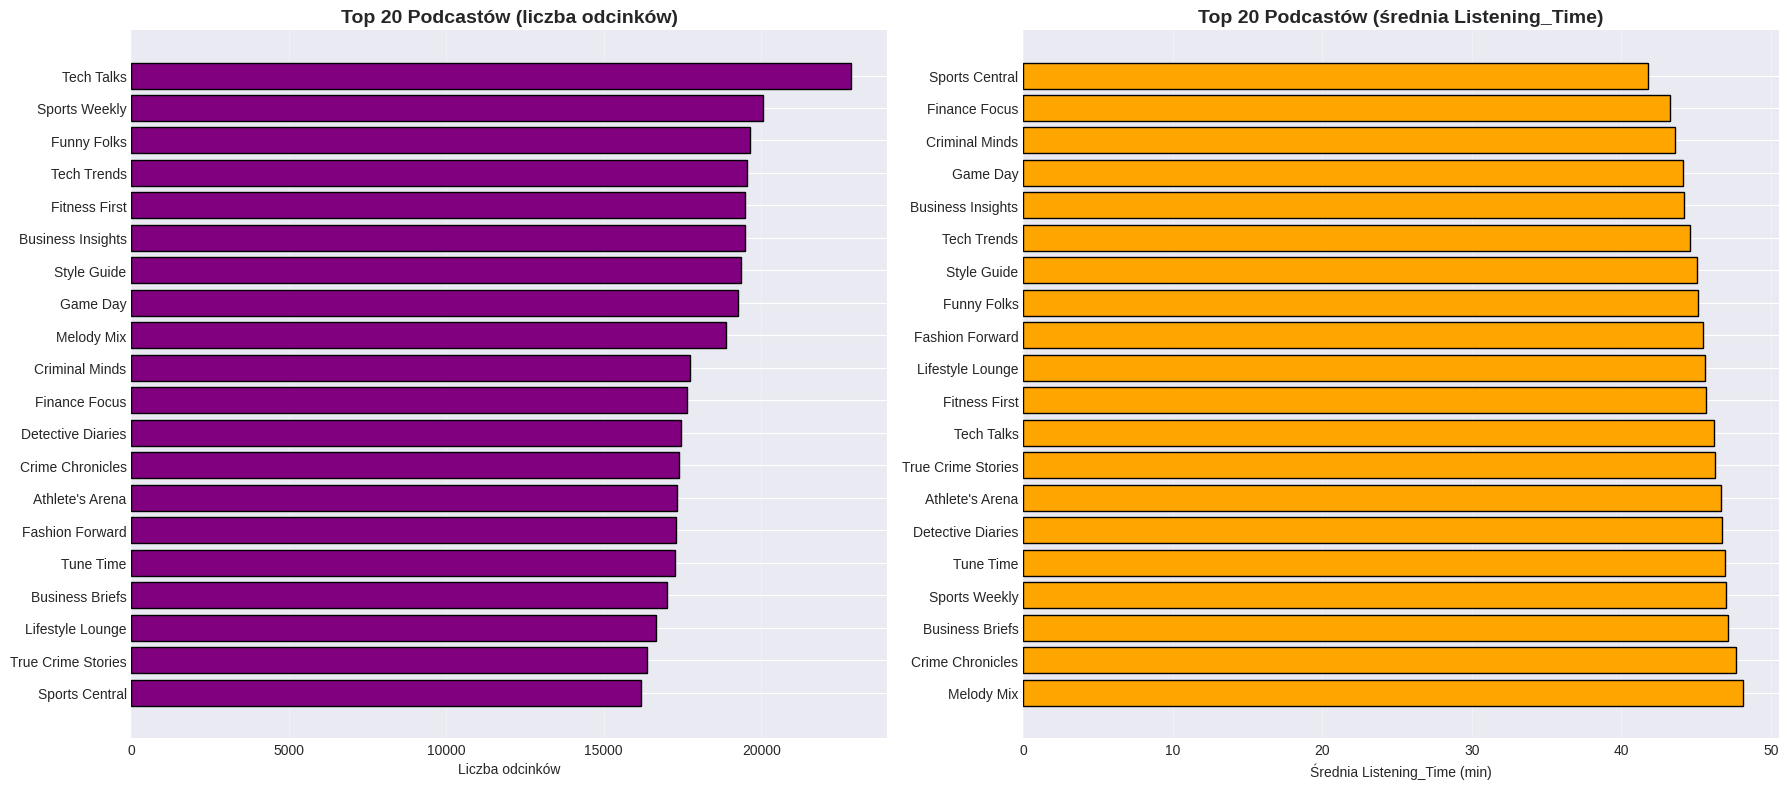


Liczba unikalnych podcastów: 48
Średnia odcinków per podcast: 15625.00


In [16]:
# Top 20 podcastów
top_podcasts = train['Podcast_Name'].value_counts().head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Liczba odcinków
axes[0].barh(top_podcasts.index, top_podcasts.values, color='purple', edgecolor='black')
axes[0].set_title('Top 20 Podcastów (liczba odcinków)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Liczba odcinków')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Średnia słuchalność top 20
top_podcast_names = top_podcasts.index
top_listening = train[train['Podcast_Name'].isin(top_podcast_names)].groupby('Podcast_Name')['Listening_Time_minutes'].mean().sort_values()
axes[1].barh(top_listening.index, top_listening.values, color='orange', edgecolor='black')
axes[1].set_title('Top 20 Podcastów (średnia Listening_Time)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Średnia Listening_Time (min)')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('top_podcasts.png', dpi=150, bbox_inches='tight')
print("Wykres zapisany: top_podcasts.png")
plt.show()

print(f"\nLiczba unikalnych podcastów: {train['Podcast_Name'].nunique()}")
print(f"Średnia odcinków per podcast: {train['Podcast_Name'].value_counts().mean():.2f}")

**Wnioski z Podcast_Name**
1. nigh cardinality (48 unikalnych nazw podcastów)
2. one-hot encoding niemozliwy - zamieniamy na embeddingi 

Analiza Episode_Sentiment

Wykres zapisany: sentiment_analysis.png


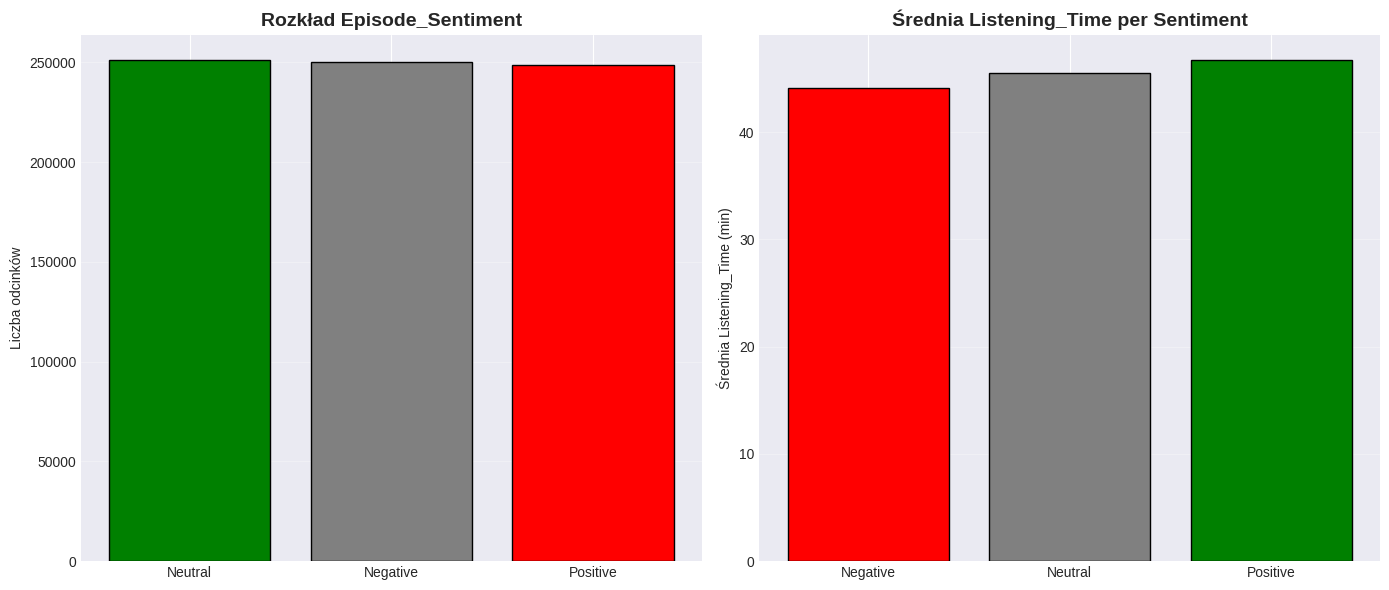


STATYSTYKI PER SENTIMENT
                    count   mean    std
Episode_Sentiment                      
Negative           250116  44.10  26.92
Neutral            251291  45.50  26.69
Positive           248593  46.72  27.73


In [4]:
sentiment_counts = train['Episode_Sentiment'].value_counts()
sentiment_listening = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Rozkład
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'], edgecolor='black')
axes[0].set_title('Rozkład Episode_Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Liczba odcinków')
axes[0].grid(True, alpha=0.3, axis='y')

# Średnia słuchalność
axes[1].bar(sentiment_listening.index, sentiment_listening.values, color=['red', 'gray', 'green'], edgecolor='black')
axes[1].set_title('Średnia Listening_Time per Sentiment', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Średnia Listening_Time (min)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=150, bbox_inches='tight')
print("Wykres zapisany: sentiment_analysis.png")
plt.show()

print(f"\n{'='*60}")
print("STATYSTYKI PER SENTIMENT")
print(f"{'='*60}")
print(train.groupby('Episode_Sentiment')['Listening_Time_minutes'].agg(['count', 'mean', 'std']).round(2))

**Wnioski z Sentiment**
1. Jeśli positive > negative -> sentiment ma znaczenie, no tu są praktycznie takie same, wiec sentiment ma malo znaczenia w sumie
2. nowy feature - sentiment_numeric (-1, 0, 1): negative, neutral, positive
3. dodajemy tez sentiment_x_host_pop, sentiment_x_guest_pop

Podsumowanie kluczowych wniosow z EDA

1. braki są informatywne, np. w "guest_popularity_percentage" braki są spowodowane solo podcastem
2. episode_length_minutes jest kluczowy, najsilniejsza korelacja z targetem
3. czas publikacji ma znaczenie
4. genre i podcast_name - zamiana na embeddingi
5. outliers - znikome wartosci, wywalamy
S

**PLAN FEATURE ENGINEERING:**

**Preprocessing:**
1. Imputacja median/mean + flagi missing
2. Winsorization outlierów (1/99 percentyl)
3. Usunięcie duplikatów (tylko train)

**Time Features:**
1. Zamiana kategorii na numery
2. Cyclic encoding (sin/cos)
3. Binarne: is_weekend, is_primetime, is_morning, is_night

**Numeric Interactions:**
1. ads_per_minute, popularity_ratio, popularity_diff
2. length_x_evening, host_pop_x_weekend

**Text Features:**
1. **EMBEDDINGI** z Episode_Title (SentenceTransformers)
2. Clustering podobnych tytułów (cosine similarity)
3. TF-IDF jako backup

**Agregacje:**
1. Per Podcast: mean, median, std, frequency
2. Per Genre: mean, median, std
3. Relative features: vs_podcast_avg, vs_genre_avg

**Target Encoding:**
1. Podcast_Name, Genre (z CV leak protection)
2. Bayesian smoothing